In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
modelo=pd.read_csv('data/modelo.csv',low_memory=False)

In [3]:
modelo.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
modelo.drop(['url', 'sku', 'skus','channel','staticpage','condition','storage','color','search_engine','device_type','campaign_source','country','region','search_term','new_vs_returning','city','region','screen_resolution','operating_system_version','browser_version'], axis=1, inplace=True)

In [5]:
training= pd.read_csv('data/training.csv',low_memory=False)

In [6]:
training.head()

,person,label
0,0566e9c1,0
1,6ec7ee77,0
2,abe7a2fb,0
3,34728364,0
4,87ed62de,0


In [7]:
len(modelo[modelo['event']=='conversion'])

7091

In [8]:
modelo[modelo['event']=='conversion']['person'].nunique()

4293

In [9]:
len(modelo[modelo['event']=='checkout'])

65315

In [10]:
modelo[modelo['event']=='checkout']['person'].nunique()

32833

# Armado del modelo

In [11]:
modelo.sort_values('person',inplace=True)

In [12]:
import calendar

modelo['timestamp'] = pd.to_datetime(modelo['timestamp'])


modelo['dia']=modelo['timestamp'].dt.dayofyear
modelo['dias_distintos'] = modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & ( modelo['timestamp'].dt.day>23) ] )['dia'].nunique().unstack()[True])   
modelo['dias_distintos']=modelo['dias_distintos'].fillna(0).astype(int)
modelo.drop('dia',1,inplace=True)



modelo['modelos_distintos_vistos']= modelo['person'].map( modelo.groupby('person')['model'].nunique())
modelo.drop('model',1,inplace=True)


modelo['campaña_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="ad campaign hit")]).size().unstack()[True]) 
modelo['campaña_ultima_semana']=modelo['campaña_ultima_semana'].fillna(0).astype(int)


modelo['busqueda_celular']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="searched products")]).size().unstack()[True]) 
modelo['busqueda_celular']=modelo['busqueda_celular'].fillna(0).astype(int)


modelo['total_visitas_usuario'] = modelo.groupby('person')['person'].transform('count')


modelo['visitas_ultimo_mes']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month)==5]).size().unstack()[True])
modelo['visitas_ultimo_mes']=modelo['visitas_ultimo_mes'].fillna(0).astype(int)


modelo['visitas_ultimos_15']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True])
modelo['visitas_ultimos_15']=modelo['visitas_ultimos_15'].fillna(0).astype(int)


modelo['visitas_ultima_semana']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True])
modelo['visitas_ultima_semana']=modelo['visitas_ultima_semana'].fillna(0).astype(int)

modelo['visitas_ultimos_3']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True])
modelo['visitas_ultimos_3']=modelo['visitas_ultimos_3'].fillna(0).astype(int)


modelo['total_checkout']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['checkout'])
modelo['total_checkout']=modelo['total_checkout'].fillna(0).astype(int)



modelo['checkouts_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['checkout'])   
modelo['checkouts_ultimo_mes']=modelo['checkouts_ultimo_mes'].fillna(0).astype(int)


"""
modelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultima_semana']=modelo['checkouts_ultima_semana'].fillna(0).astype(int)



modelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])
modelo['total_compras']=modelo['total_compras'].fillna(0).astype(int)



modelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimo_mes']=modelo['compras_ultimo_mes'].fillna(0).astype(int)



modelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultima_semana']=modelo['compras_ultima_semana'].fillna(0).astype(int)


modelo['subscripciones_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['lead'])
modelo['subscripciones_ultimo_mes']=modelo['subscripciones_ultimo_mes'].fillna(0).astype(int)
"""


"\nmodelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])\nmodelo['checkouts_ultima_semana']=modelo['checkouts_ultima_semana'].fillna(0).astype(int)\n\n\n\nmodelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])\nmodelo['total_compras']=modelo['total_compras'].fillna(0).astype(int)\n\n\n\nmodelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])\nmodelo['compras_ultimo_mes']=modelo['compras_ultimo_mes'].fillna(0).astype(int)\n\n\n\nmodelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])\nmodelo['compras_ultima_semana']=modelo['compras_

In [13]:
modelo=modelo.drop_duplicates(subset=['person'])
modelo.drop(['timestamp','event'], 1, inplace=True)

In [14]:
modelo=pd.merge(modelo, training, on='person', how='left')

In [15]:
modelo.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0.0
1,00091926,4,36,6,0,448,448,261,47,19,2,2,NaN
2,00091a7a,0,3,0,0,10,0,0,0,0,0,0,NaN
3,000ba417,2,26,0,0,206,206,206,138,0,6,6,NaN
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0.0


In [16]:
a_predecir=modelo[modelo['label'].isnull()]
a_predecir.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
1,00091926,4,36,6,0,448,448,261,47,19,2,2,NaN
2,00091a7a,0,3,0,0,10,0,0,0,0,0,0,NaN
3,000ba417,2,26,0,0,206,206,206,138,0,6,6,NaN
5,000e4d9e,5,37,0,0,411,411,411,112,75,1,1,NaN
6,000e619d,0,23,0,0,68,68,58,0,0,1,1,NaN


In [17]:
modelo.drop(modelo[modelo['label'].isnull()].index,inplace=True)
modelo['label']=modelo['label'].astype(int)
modelo.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0
10,001802e4,1,2,5,4,19,19,19,19,19,1,1,0
12,0019e639,0,26,0,0,471,290,136,0,0,15,4,0
14,001b0bf9,0,1,0,0,7,7,7,0,0,2,2,0


In [18]:
len(modelo[modelo['label']==1]),len(modelo[modelo['label']==0]) 

(980, 18434)

In [19]:
len(modelo[modelo['label']==1])*100/len(modelo['label']),len(modelo[modelo['label']==0])*100/len(modelo['label'])

(5.047903574739879, 94.95209642526012)

In [20]:
modelo[modelo['label']==1].head(15)

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
31,003476c0,0,2,0,0,43,14,0,0,0,0,0,1
38,003d4cac,0,2,0,0,8,0,0,0,0,1,0,1
39,003dd965,0,0,0,0,5,5,5,0,0,0,0,1
43,0042421c,0,5,0,0,22,0,0,0,0,0,0,1
57,006671fd,0,5,0,0,18,0,0,0,0,0,0,1
178,0143d796,1,3,1,0,24,24,24,24,24,1,1,1
272,01ed2afc,0,1,0,0,7,7,7,0,0,0,0,1
358,02875920,1,3,2,6,29,22,17,17,0,0,0,1
501,03754d73,1,1,0,0,37,9,9,9,0,0,0,1
559,03c99f07,2,3,6,17,43,43,43,43,43,0,0,1


In [21]:
modelo[modelo['label']==0].head(15)

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0
10,001802e4,1,2,5,4,19,19,19,19,19,1,1,0
12,0019e639,0,26,0,0,471,290,136,0,0,15,4,0
14,001b0bf9,0,1,0,0,7,7,7,0,0,2,2,0
15,001ca5ee,0,6,0,0,96,54,17,0,0,1,1,0
16,001dfc31,1,4,2,0,35,17,17,17,17,0,0,0
17,001e9aea,0,6,0,0,54,5,3,0,0,3,0,0
18,0020152e,1,2,1,0,9,9,6,6,6,2,2,0
24,002b0188,0,9,0,0,38,26,26,0,0,1,0,0


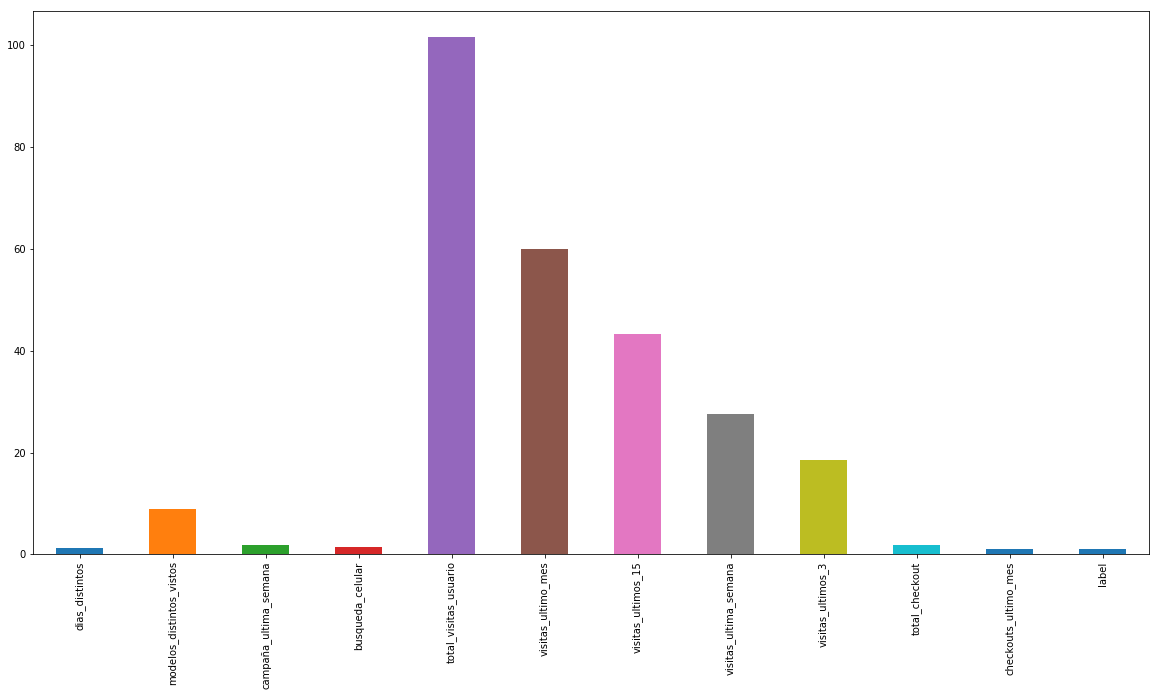

In [22]:
modelo[modelo['label']==1].mean().plot(kind='bar',figsize=(20,10))

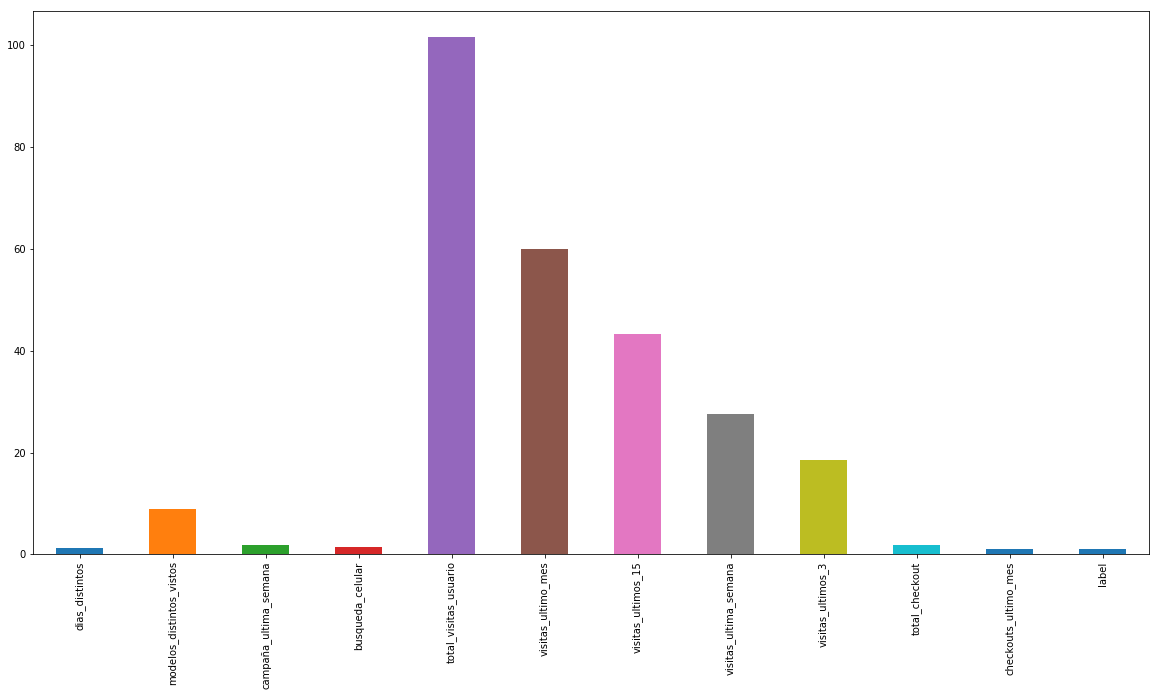

In [23]:
modelo[modelo['label']==1].mean().plot(kind='bar',figsize=(20,10))

In [24]:
modelo[modelo['label']==1].mean()-modelo[modelo['label']==0].mean()

dias_distintos               0.280920
modelos_distintos_vistos     3.446072
campaña_ultima_semana        0.343258
busqueda_celular             0.586515
total_visitas_usuario       43.553997
visitas_ultimo_mes          16.661781
visitas_ultimos_15           9.752915
visitas_ultima_semana       10.056608
visitas_ultimos_3            8.237521
total_checkout               0.165994
checkouts_ultimo_mes        -0.411831
label                        1.000000
dtype: float64

## MACHINE LEARNING

In [25]:
##Ahora empieza ML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

## Resample

In [27]:
from sklearn.utils import resample
df_minority_upsampled = resample(modelo[modelo['label']==1], 
                                 replace=True,     # sample with replacement
                                 n_samples=18434,    # to match majority class
                                 random_state=123) # reproducible results
modelo = pd.concat([modelo[modelo['label']==0], df_minority_upsampled])

In [32]:
X = modelo.drop(['person','label'], axis=1)
y = modelo['label']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) 

In [34]:
len(X_train),len(X_test),len(y_train),len(y_test)

(29494, 7374, 29494, 7374)

In [35]:
X_train.head()

,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes
31510,4,5,32,0,86,86,86,86,76,0,0
30280,2,2,0,11,53,53,53,30,30,6,6
17439,0,5,0,0,38,38,38,0,0,1,1
22671,1,3,1,8,19,19,19,19,0,0,0
16436,0,14,0,0,46,0,0,0,0,1,0


In [36]:
y_train.head()

31510    1
30280    1
17439    0
22671    1
16436    1
Name: label, dtype: int32

In [37]:
X_test.head()

,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes
20599,0,18,0,0,70,14,0,0,0,1,0
34213,0,1,0,0,4,4,4,0,0,1,1
35544,1,1,2,0,8,8,8,8,8,1,1
31186,0,41,0,0,412,355,0,0,0,0,0
3082,1,3,2,0,21,21,12,12,0,0,0


In [38]:
y_test.head()

20599    1
34213    0
35544    0
31186    1
3082     1
Name: label, dtype: int32

In [39]:
len(y_test[y_test == 1]),len(y_test[y_test == 0])

(3729, 3645)

## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
my_classifier= KNeighborsClassifier()
my_classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
predictions= my_classifier.predict(X_test)
accuracy_score(y_test,predictions)

0.9133441822620016

In [42]:
my_matrix = metrics.confusion_matrix(y_test, predictions)
my_matrix

array([[3082,  563],
       [  76, 3653]], dtype=int64)

## DECISION TREE

In [43]:
from sklearn import tree
my_classifier2= tree.DecisionTreeClassifier()
my_classifier2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
predictions2= my_classifier2.predict(X_test)
accuracy_score(y_test,predictions2)

0.9567398969351777

In [45]:
my_matrix2 = metrics.confusion_matrix(y_test, predictions2)
my_matrix2

array([[3352,  293],
       [  26, 3703]], dtype=int64)

## RANDOM FOREST

In [46]:
from sklearn.ensemble import RandomForestClassifier
my_classifier3 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
my_classifier3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
predictions3=my_classifier3.predict(X_test)
accuracy_score(y_test, predictions3)

0.8072959045294277

In [48]:
my_matrix3 = metrics.confusion_matrix(y_test, predictions3)
my_matrix3

array([[2821,  824],
       [ 597, 3132]], dtype=int64)

## Logistic regression

In [49]:
from sklearn.linear_model import LogisticRegression
my_classifier4 = LogisticRegression()
my_classifier4.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
predictions4 = my_classifier4.predict(X_test)
accuracy_score(y_test, predictions4)

0.646460537021969

In [51]:
my_matrix4 = metrics.confusion_matrix(y_test, predictions4)
my_matrix4

array([[2877,  768],
       [1839, 1890]], dtype=int64)

## Neuronal Network

In [52]:
from sklearn.neural_network import MLPClassifier
my_classifier5 = MLPClassifier(max_iter=100000,hidden_layer_sizes=(100,100,100) )
my_classifier5.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [53]:
predictions5 = my_classifier5.predict(X_test)
accuracy_score(y_test, predictions5)

0.9087333875779767

In [54]:
my_matrix5 = metrics.confusion_matrix(y_test, predictions5)
my_matrix5

array([[3170,  475],
       [ 198, 3531]], dtype=int64)

## Naive Bayes

In [55]:
from sklearn.naive_bayes import GaussianNB
my_classifier6 = GaussianNB()
my_classifier6.fit(X_train,y_train)

GaussianNB(priors=None)

In [56]:
predictions6 = my_classifier6.predict(X_test)
accuracy_score(y_test, predictions6)

0.5531597504746406

In [57]:
metrics.confusion_matrix(y_test, predictions6)

array([[3255,  390],
       [2905,  824]], dtype=int64)

## SVM

In [75]:
from sklearn import svm
my_classifier7 =svm.SVC()
my_classifier7.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
predictions7 = my_classifier7.predict(X_test)
accuracy_score(y_test, predictions7)

0.9491456468673718

In [77]:
metrics.confusion_matrix(y_test, predictions7)

array([[3327,  318],
       [  57, 3672]], dtype=int64)

## AdaBoost

In [62]:
from sklearn.ensemble import AdaBoostClassifier
my_classifier8 = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
my_classifier8.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

In [63]:
predictions8 = my_classifier8.predict(X_test)
accuracy_score(y_test, predictions8)

0.7979387035530241

In [64]:
metrics.confusion_matrix(y_test, predictions8)

array([[2905,  740],
       [ 750, 2979]], dtype=int64)

## Voting Classifier

In [65]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=1000,random_state=1,n_jobs =-1)
clf3 = GaussianNB(priors=[0.05,0.95])
clf4= MLPClassifier()
clf5= tree.DecisionTreeClassifier()
#clf6= svm.SVC()
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3) , ('dt',clf5), ('svm',clf4)], voting='soft', n_jobs =-1)
eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
accuracy_score(y_test, predictions)


d:\programas\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9441280173582859

In [66]:
metrics.confusion_matrix(y_test, predictions)

array([[3281,  364],
       [  48, 3681]], dtype=int64)

In [67]:
#clf1 = LogisticRegression(solver='sag', multi_class='ovr', random_state=1 , n_jobs=-1)
#clf2 = RandomForestClassifier(n_estimators=1000,random_state=1,n_jobs =-1)
clf3 = GaussianNB()
#clf4= MLPClassifier()
clf5= tree.DecisionTreeClassifier()
clf6= svm.SVC()
eclf2 = VotingClassifier(estimators=[('lr', clf3), ('dt', clf5),('svm', clf6)], voting='soft', n_jobs =-1)
eclf2 = eclf1.fit(X_train, y_train)
predictions2 = eclf2.predict(X_test)
accuracy_score(y_test, predictions2)

d:\programas\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9439924057499322

In [68]:
metrics.confusion_matrix(y_test, predictions2)

array([[3276,  369],
       [  44, 3685]], dtype=int64)

## ROC AUC SCORE

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions)

0.9436325452713522

In [70]:
roc_auc_score(y_test, predictions2)

0.9434830110346334

## KAGGLE PREDICTIONS

In [71]:
kaggle= pd.read_csv('data/kaggle.csv',low_memory=False)

In [72]:
kaggle=pd.merge(kaggle, a_predecir, on='person', how='inner')

In [73]:
kaggle.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,4886f805,0,1,0,0,9,9,9,0,0,1,1,NaN
1,0297fc1e,4,15,1,0,567,173,126,53,8,7,2,NaN
2,2d681dd8,1,3,1,1,26,26,26,16,0,1,1,NaN
3,cccea85e,4,57,5,1,836,836,449,270,252,1,1,NaN
4,4c8a8b93,0,9,0,0,257,257,257,0,0,2,2,NaN


In [74]:
np.savetxt("predictions.csv", eclf1.predict_proba(kaggle.drop(['person','label'], axis=1))  , delimiter=",")